In [1]:
import time
import math
from math import *
import numpy as np
import scipy
from scipy import special
from scipy import optimize
from scipy.integrate import quad
from scipy.misc import derivative
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
data = np.loadtxt('ACH.dat')

In [3]:
Lbox = 1100
hLbox = Lbox/2

Nt = 114528
#Nt = 100000
nbar = Nt / Lbox**3

nk = 7
fbasis = np.zeros(nk+1)

nr = 21
rmin = 60
rmax = 120
rmid = (rmax+rmin)/2
mu = rmid
sigma = 4.6
c = -mu/sigma

In [4]:
sample = np.random.choice(len(data),size=Nt,replace=False)

In [5]:
x, y, z = data[sample].T

In [6]:
def E1(s):
    return special.erf(s/sqrt(2))

def E2(s):
    return sqrt(2/pi)*np.exp(-s**2/2)

def f0(s):
    return s**0

def f1(s):
    return (s+1/s) * E1(s) + E2(s)

def f2(s):
    return 3 + s**2

def f3(s):
    return (s**3+6*s+3/s) * E1(s) + (s**2+5) * E2(s)

def f4(s):
    return s**4+10*s**2+15

def f5(s):
    return (s**5+15*s**3+45*s+15/s) * E1(s) + (s**2+3)*(s**2+11) * E2(s)

def f6(s):
    return s**6 + 21*s**4 + 105*s**2 + 105

def f7(s):
    return (s**7+28*s**5+210*s**3+420*s+105/s)* E1(s) + (s**6+27*s**4+185*s**2+279)*E2(s)

#def f8(s):
 #   return s**8 + 36*s**6 + 378*s**4 + 1260*s**2 + 945

In [7]:
f = [f0,f1,f2,f3,f4,f5,f6,f7]

In [8]:
def nu0(s):
    return f0(s)

def nu1(s):
    res = 0
    for l in range(2):
        res += scipy.special.comb(1,l) * c**(1-l) * f[l](s)
    return res

def nu2(s):
    res = 0
    for l in range(3):
        res += scipy.special.comb(2,l) * c**(2-l) * f[l](s)
    return res

def nu3(s):
    res = 0
    for l in range(4):
        res += scipy.special.comb(3,l) * c**(3-l) * f[l](s)
    return res

def nu4(s):
    res = 0
    for l in range(5):
        res += scipy.special.comb(4,l) * c**(4-l) * f[l](s)
    return res

def nu5(s):
    res = 0
    for l in range(6):
        res += scipy.special.comb(5,l) * c**(5-l) * f[l](s)
    return res

def nu6(s):
    res = 0
    for l in range(7):
        res += scipy.special.comb(6,l) * c**(6-l) * f[l](s)
    return res

def nu7(s):
    res = 0
    for l in range(8):
        res += scipy.special.comb(7,l) * c**(7-l) * f[l](s)
    return res

def nu8(s):
    res = 0
    for l in range(9):
        res += scipy.special.comb(8,l) * c**(8-l) * f[l](s)
    return res

In [9]:
nu = [nu0,nu1,nu2,nu3,nu4,nu5,nu6,nu7]

In [10]:
t0 = time.time()

Nb = np.zeros(nr)

for i in tqdm(range(Nt-1)):
    j = np.arange(i+1,Nt)
    
    dx = x[i] - x[j]
    dy = y[i] - y[j]
    dz = z[i] - z[j]
        
    ### periodic boundary conditions on separations: 
    dx[np.where(dx>hLbox)] -= Lbox
    dy[np.where(dy>hLbox)] -= Lbox
    dz[np.where(dz>hLbox)] -= Lbox
    dx[np.where(dx<-hLbox)] += Lbox
    dy[np.where(dy<-hLbox)] += Lbox
    dz[np.where(dz<-hLbox)] += Lbox

    r2 = dx**2 + dy**2 + dz**2
    r = np.sqrt(r2)
    
    ### bin pair counts:
    hi, bins = np.histogram(r, bins=nr, range=(rmin,rmax))
    Nb += hi
    
    ### Laguerre pair counts:
    r = r[(r>=rmin) & (r<=rmax)]
    if len(r) > 0:
        s = r/sigma
        for k in range(nk+1):
            fbasis[k] += np.sum(nu[k](s))/Nt
    
        
fbasis = fbasis*2 / (Nt-1)
    

t1 = time.time() 
print('Time =', t1-t0)

100%|██████████| 114527/114527 [14:25<00:00, 132.30it/s]

Time = 865.7834219932556


In [11]:
DD = 2*Nb

dr = bins[1] - bins[0]
rbin = (bins[1:] + bins[:-1])/2

RR = (Nt-1)*nbar*4*pi/3*(bins[1:]**3-bins[:-1]**3)
        
xi12 = DD/RR - 1  

sqrtN = np.sqrt(2*Nb)
errxi = sqrtN/RR

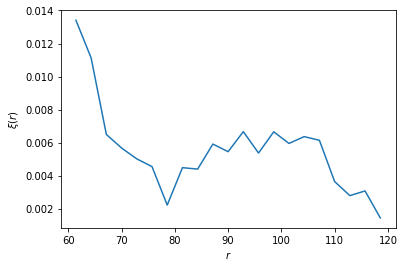

In [24]:
### plot binned xi:
plt.plot(rbin,xi12)
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.show()

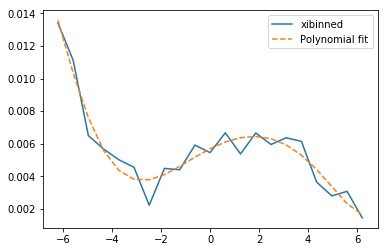

In [29]:
### check if a polynomial is an ok fit to it:
xbin = (rbin - mu)/sigma
aFit = np.polyfit(xbin, xi12, nk)
p = np.poly1d(aFit)
plt.plot(xbin,xi12, xbin, p(xbin), '--')
plt.legend(["xibinned", "Polynomial fit"])
plt.show()

In [15]:
### setting up the vector of RR:
V = np.zeros(nk+1)
for k in range(nk+1):
    fun = lambda r: r**2 * nu[k](r/sigma)
    V[k] = quad(fun,rmin, rmax)[0]

    
nuRR = 4*pi/Lbox**3*V[0:nk+1]

In [16]:
### the corresponding F_RR:
dim = (nk+1, nk+1)
FRR = np.zeros(dim)
for k in range(nk+1):
    for l in range(k,nk+1):
        func = lambda r: r**2 * nu[k](r/sigma) * nu[l](r/sigma)
        FRR[k,l] = (4*pi/Lbox**3)*quad(func, rmin, rmax)[0]
        FRR[l,k] = FRR[k,l]

In [17]:
invF = np.linalg.inv(FRR)

In [18]:
nuDD = fbasis
simDiff = nuDD - nuRR
aSim = np.zeros(nk+1)
aSim = np.dot(invF, simDiff)
print ('Sim:', aSim)
checkDiff = 0*simDiff
for k in range(nk+1):
    checkDiff[k] = sum(FRR[k,:]*aSim[:])

Sim: [  5.90559771e-03   8.54423168e-04  -2.01107111e-04  -2.25005552e-05
   7.95803042e-06  -1.50469931e-06  -4.63583611e-08   2.07481719e-08]


In [19]:
rt = np.arange(60,121)
yt = rt/sigma
xiNL = 0.0*rt
for k in range(nk+1):
    xiNL += aSim[k] * nu[k](yt)

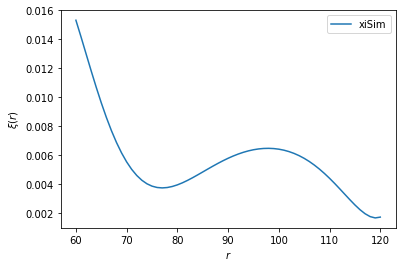

In [26]:
### plot unbinned Laguerre fit: 
plt.plot(rt,xiNL)
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend(["xiSim"])
plt.show()

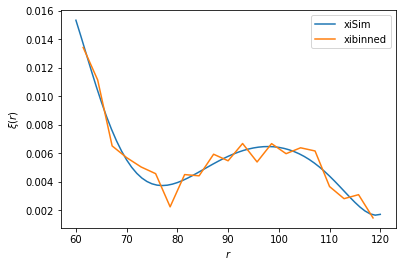

In [27]:
plt.plot(rt,xiNL)
plt.plot(rbin,xi12)
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend(["xiSim", "xibinned"])
plt.show()

In [22]:
ytable = (rt-mu)/sigma
xiRec = 0.0*rt
for k in range(nk+1):
    xiRec += aSim[k] * ytable**(k)

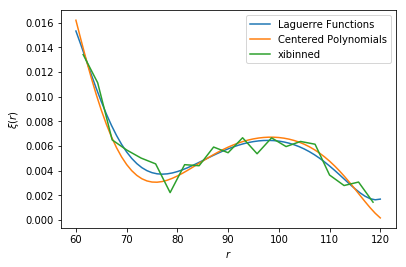

In [28]:
plt.plot(rt,xiNL)       ### the whole data
plt.plot(rt,xiRec)
plt.plot(rbin,xi12)
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend(["Laguerre Functions", "Centered Polynomials", "xibinned"])
plt.show()

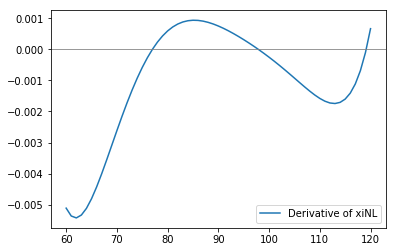

In [30]:
### defining xiNL
def xiN(x):
    res = 0
    for k in range(nk+1):
        res += aSim[k] * nu[k](x)       
    return res

### calculating its derivative
def xiNLp(x):
    return derivative(xiN, x, dx=0.1)

yN = rt/sigma

plt.plot(rt, xiNLp(yN))
plt.axhline(0, color='gray', lw=0.8)
plt.legend(["Derivative of xiNL"])
plt.show()

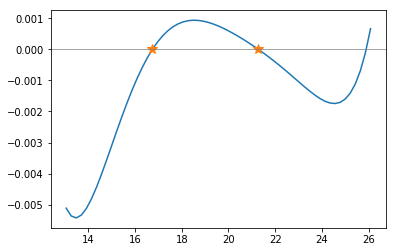

rdip =  77.0115744558
rpeak =  97.8562234296
rLP =  87.4338989427


In [31]:
### finding the roots of xiNLp
sol1 = optimize.root(xiNLp, [16,22])

plt.plot(yN, xiNLp(yN))
plt.plot(sol1.x, xiNLp(sol1.x), '*', ms=10)
plt.axhline(0, color='gray', lw=0.7)
plt.show()

root1 = sigma*sol1.x
print('rdip = ', root1[0])
print('rpeak = ', root1[1])
print('rLP = ', (root1[0]+root1[1])/2)

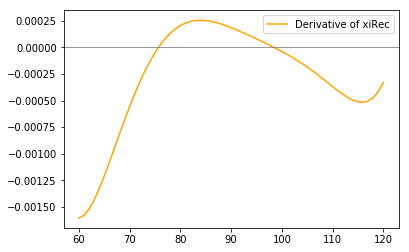

In [32]:
### defining xiRec
def xiR(x):
    res = 0
    for k in range(nk+1):
        res += aSim[k] * x**k
    return res

### calculating its derivative
def xiRecp(x):
    res = 0
    for k in range(1,nk+1):
        res += aSim[k] * (k/sigma) * x**(k-1) 
    return res

yR = (rt-mu)/sigma

plt.plot(rt, xiRecp(yR), color='orange')
plt.axhline(y=0, color='gray', lw=0.8)
plt.legend(["Derivative of xiRec"])
plt.show()

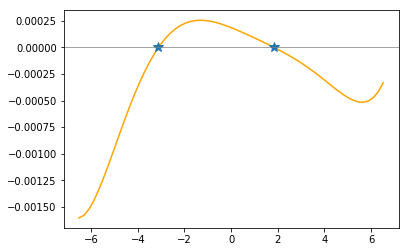

rdipRec =  75.6832303455
rpeakRec =  98.4428671384
rLPrec =  87.0630487419


In [34]:
### finding the roots of xiRp
sol2 = optimize.root(xiRecp, [-4,4])

plt.plot(yR, xiRecp(yR), color='orange')
plt.plot(sol2.x, xiRecp(sol2.x), '*', ms=10)
plt.axhline(0, color='gray', lw=0.7)
plt.show()

root2 = sigma*sol2.x + mu
print('rdipRec = ', root2[0])
print('rpeakRec = ', root2[1])
print('rLPrec = ', (root2[0]+root2[1])/2)

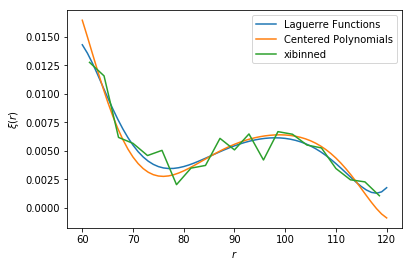

In [145]:
plt.plot(rt,xiSim)        ### (1) Nt = 10^5
plt.plot(rt,xipoly)
plt.plot(rbin,xi12)
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend(["Laguerre Functions", "Centered Polynomials", "xibinned"])
plt.show()

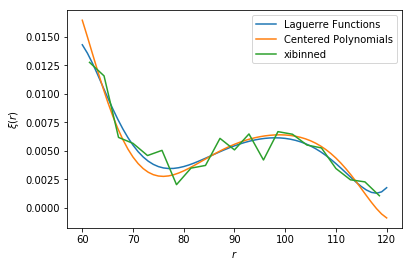

In [132]:
plt.plot(rt,xiSim)        ### (2) Nt = 10^5
plt.plot(rt,xipoly)
plt.plot(rbin,xi12)
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend(["Laguerre Functions", "Centered Polynomials", "xibinned"])
plt.show()

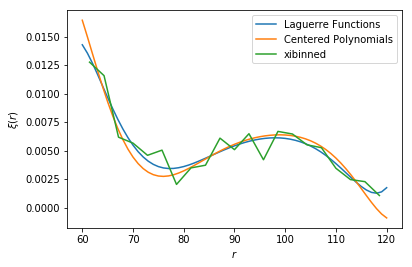

In [119]:
plt.plot(rt,xiSim)        ### (3) Nt = 10^5
plt.plot(rt,xipoly)
plt.plot(rbin,xi12)
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend(["Laguerre Functions", "Centered Polynomials", "xibinned"])
plt.show()

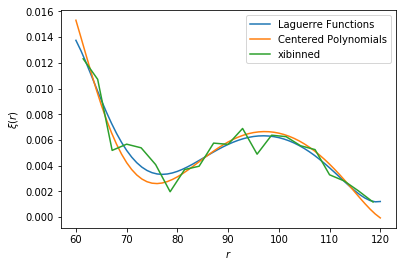

In [99]:
plt.plot(rt,xiSim)        ### (4) Nt = 10^5
plt.plot(rt,xipoly)
plt.plot(rbin,xi12)
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend(["Laguerre Functions", "Centered Polynomials", "xibinned"])
plt.show()

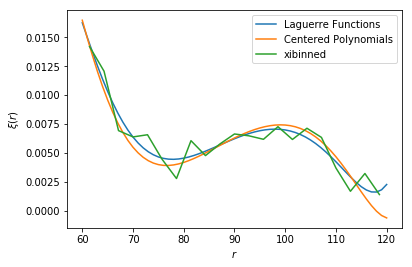

In [79]:
plt.plot(rt,xiSim)        ### (5) Nt = 10^5
plt.plot(rt,xipoly)
plt.plot(rbin,xi12)
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend(["Laguerre Functions", "Centered Polynomials", "xibinned"])
plt.show()

In [166]:
k = np.arange(nk+1)
coef = np.zeros(nk+1)
for i in range(nk+1):
    coef[i] = math.factorial(i)*aSim[i] 

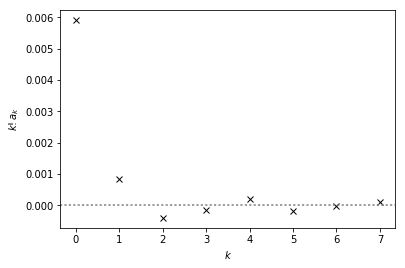

In [167]:
plt.plot(k, coef, 'x', color='black')
plt.axhline(y=0, color='gray', linestyle='dotted')
plt.ylabel(r'$k! a_k$')
plt.xlabel(r'$k$')
plt.show()